# Introduction to Multi-Layer Perceptrons (MLPs)

Welcome! This tutorial introduces the concept of Multi-Layer Perceptrons (MLPs), a fundamental type of feedforward Artificial Neural Network (ANN). We'll cover:
1.  **What MLPs are:** The basic structure and components.
2.  **How they learn:** The concepts of forward pass, loss calculation, and backpropagation .
3.  **Implementation in PyTorch:** Building and training an MLP to solve a simple regression problem: fitting a sine wave.

MLPs are powerful tools capable of approximating complex, non-linear functions, making them suitable for various tasks in science and engineering.

## 1. What is an MLP?

![Screenshot 2025-04-07 at 4.18.18 PM.png](<attachment:Screenshot 2025-04-07 at 4.18.18 PM.png>)

An MLP is a type of neural network organized into layers:

*   **Input Layer:** Receives the raw input data (features). The number of neurons in this layer corresponds to the number of input features. In our case this may correspond to the dimensionality of the function we're looking to fit.
*   **Hidden Layers:** One or more layers between the input and output layers. These layers transform the input data through weighted connections and non-linear activation functions, allowing the network to learn complex patterns. The number of hidden layers and the number of neurons in each layer is a hyperparameter that can be tuned. There's no rule of thumb for this - it's something that you have to experiment with.
*   **Output Layer:** Produces the final prediction. The number of neurons depends on the task (e.g., n-dimensional output for n-dimensional regression, N for N-class classification).

**Components:**
*   **Neurons (Nodes):** Perform computations. Each neuron receives inputs, applies weights and a bias, and then passes the result through an activation function.
*   **Weights & Biases:** Parameters the network learns during training. Weights determine the strength of connections between neurons, and biases shift the activation function's output.
*   **Activation Functions:** Introduce non-linearity, enabling the network to learn more than just linear relationships. Common examples include ReLU (Rectified Linear Unit), Sigmoid, and Tanh (Hyperbolic Tangent). Without non-linear activations, an MLP, no matter how many layers, would behave like a simple linear model.

### The Power of MLPs: Universal Approximation Theorem**

The [**Universal Approximation Theorem (UAT)**](https://en.wikipedia.org/wiki/Universal_approximation_theorem) states that an MLP with **at least one hidden layer**, a **finite number of neurons**, and a **non-linear activation function** (e.g., Sigmoid, Tanh, or ReLU) can approximate **any continuous function** on compact subsets of $\mathbb{R}^n$ to an arbitrary degree of accuracy. This means that theoretically MLPs can model any function given enough neurons and layers.

#### What does this mean?

- **Versatility:** MLPs can model complex input-output relationships, including highly non-linear patterns.
- **Architecture Requirement:** At least one hidden layer with non-linear activation is essential; purely linear networks can only represent linear functions.
- **Capacity:** Complex functions may require wide hidden layers or multiple layers. Deep networks are often more efficient for hierarchical features although theoretically, a single hidden layer with enough neurons can also model any function.

#### Caveats:
- The UAT guarantees the *existence* of such a network but doesn’t specify the number of neurons, optimal architecture, or ease of training.
- Training success depends on data quality, optimization algorithms (e.g., Adam, SGD), and architecture choices.

Despite these limitations, the UAT underscores why MLPs and deep networks are powerful tools for function approximation across diverse fields.
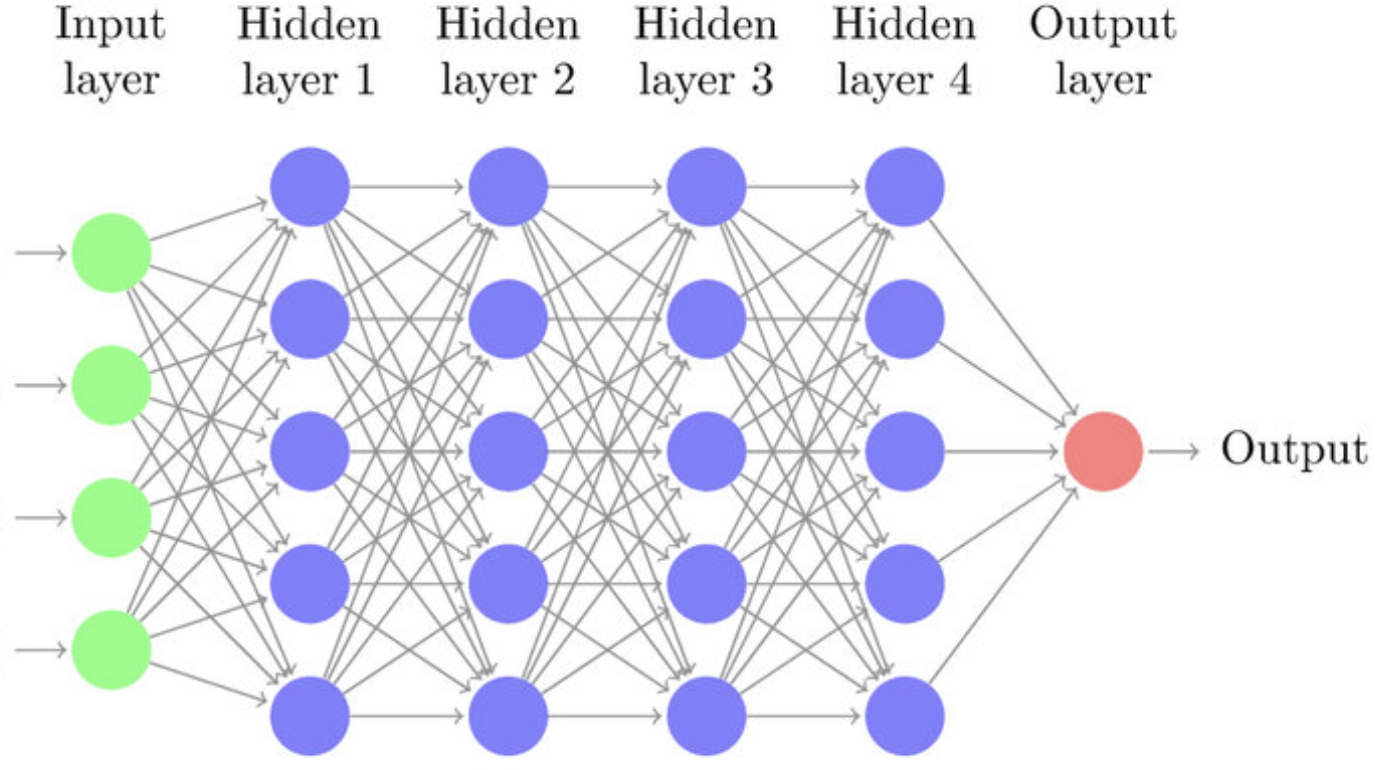

## 2. How MLPs Learn: The Forward and Backward Pass

**Forward Pass:**
Input data flows through the network layer by layer. At each layer `l`:
1.  A linear transformation is applied: `z^(l) = W^(l) * a^(l-1) + b^(l)`
    *   `a^(l-1)` is the activation (output) from the previous layer (or the input data for the first layer).
    *   `W^(l)` is the weight matrix for layer `l`.
    *   `b^(l)` is the bias vector for layer `l`.
2.  An activation function `g` is applied: `a^(l) = g(z^(l))`
This process repeats until the output layer produces a prediction (`y_pred`).

**Learning (Training):**
1.  **Loss Calculation:** Compare the network's prediction (`y_pred`) with the true target (`y_true`) using a **loss function** (e.g., Mean Squared Error for regression). The loss quantifies how wrong the prediction is.
    *   `Loss = L(y_pred, y_true)`
2.  **Backpropagation:** Calculate the gradient (derivative) of the loss function with respect to each weight and bias in the network. This tells us how much a small change in each parameter would affect the loss. A key tool here that has really helped on this front is the development of automatic differentiation (autodiff) in libraries like PyTorch and TensorFlow. At the most fundamental level, autodiff leverages the chain rule of calculus to compute the gradient of the loss with respect to each parameter.

3.  **Optimization:** Use an **optimizer** (e.g., Stochastic Gradient Descent (SGD), Adam) to update the weights and biases in the direction that minimizes the loss, using the calculated gradients. At a basic level, an optimizer essentially takes iterative steps to minimize the loss function by updating the parameters in the direction of the negative gradient.
    *   `parameter = parameter - learning_rate * gradient`

This cycle (forward pass, loss calculation, backpropagation, optimization) is repeated many times (epochs) over the training dataset, gradually improving the network's ability to make accurate predictions.

## 3. PyTorch Implementation: Fitting `y = sin(x)`

Let's build an MLP to learn the sine function. Our input `x` will be a single number, and the output `y` should be `sin(x)`.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time # used for timing function run times

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/opt/anaconda3/envs/mlenv/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Using device: cpu


### Defining the Dataset
We'll create $x$ values in a specific range (in our case we consider $[0, 2\pi]$) and calculate the corresponding $y = \sin(x)$.

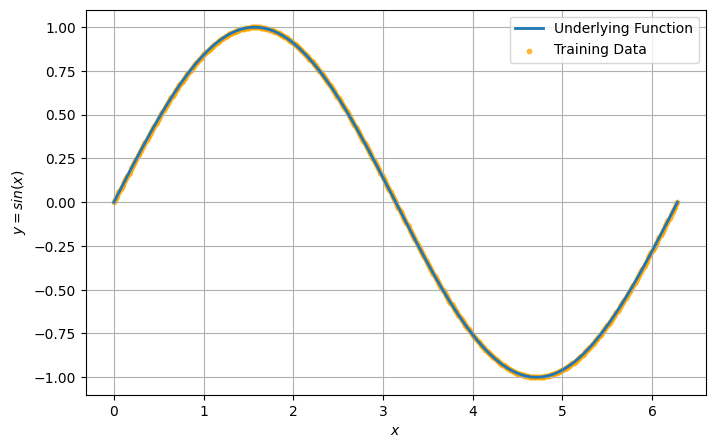

In [2]:
# Generate x values
num_samples = 500
x = torch.linspace(0, 2 * np.pi, num_samples).unsqueeze(1)

# Generate y = sin(x)
y_true = torch.sin(x)

# Move data to the selected device
x_train = x.to(device)
y_train = y_true.to(device)

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(x.numpy(), y_true.numpy(), label='Underlying Function', linewidth=2)
plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), label='Training Data', s=10, alpha=0.7, color='orange')
plt.xlabel(r"$x$")
plt.ylabel(r"$y = sin(x)$")
plt.legend()
plt.grid(True)
plt.show()

### Building the MLP Model

We define our MLP as a class inheriting from `torch.nn.Module`. We need to define the layers in `__init__` and the forward pass logic in the `forward` method.

We'll use:
*   An input layer implicitly defined by the first `nn.Linear` layer (1 input feature).
*   Two hidden layers with $\mathrm{ReLU}(x) = \max(0, x)$ activation function.
*   An output layer with 1 neuron (predicting a single value `y`). No activation is needed here for regression.

In [3]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.output_layer(x)
        return x

# Instantiate the model
input_dim = 1
hidden_dim = 8
output_dim = 1

model = MLP(input_dim, hidden_dim, output_dim).to(device)
print("Model Architecture:")
print(model)

Model Architecture:
MLP(
  (layer1): Linear(in_features=1, out_features=8, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (activation2): ReLU()
  (output_layer): Linear(in_features=8, out_features=1, bias=True)
)


### Defining Loss Function and Optimizer

*   **Loss Function:** Since this is a regression problem (predicting a continuous value), Mean Squared Error (MSE) is a suitable loss function.
\begin{align}
    \mathcal{L}_{\text{MSE}}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2
\end{align}
*   **Optimizer:** Adam is a popular and effective optimization algorithm. You can choose other optimizers like SGD, RMSprop, etc but Adam is a good default choice. You can think of Adam as performing gradient descent in a way that is adaptive to the parameters and an improvement over simple gradient descent. We need to pass the model's parameters (`model.parameters()`) and a learning rate (`lr`) to it.

In [4]:
# Loss Function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.0001 # Adjusted learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")

Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


### Training Loop

Now we implement the core training loop: iterate multiple times (epochs), perform forward pass, calculate loss, perform backpropagation, and update weights.

In [5]:
num_epochs = 20000 # Increased epochs for better convergence
print_every = 1000 # Print loss every 1000 epochs

losses = [] # To store loss values for plotting

print("\nStarting Training...")
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Forward pass: Get predictions
    outputs = model(x_train)

    # Calculate loss
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad() # Clear previous gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update weights

    # Record loss
    losses.append(loss.item())

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2e}')

print("Training Finished!")


Starting Training...
Epoch [1000/20000], Loss: 1.49e-01
Epoch [2000/20000], Loss: 9.77e-02
Epoch [3000/20000], Loss: 7.25e-02
Epoch [4000/20000], Loss: 5.66e-02
Epoch [5000/20000], Loss: 4.09e-02
Epoch [6000/20000], Loss: 2.58e-02
Epoch [7000/20000], Loss: 1.36e-02
Epoch [8000/20000], Loss: 5.27e-03
Epoch [9000/20000], Loss: 1.85e-03
Epoch [10000/20000], Loss: 6.46e-04
Epoch [11000/20000], Loss: 2.69e-04
Epoch [12000/20000], Loss: 1.54e-04
Epoch [13000/20000], Loss: 1.17e-04
Epoch [14000/20000], Loss: 1.01e-04
Epoch [15000/20000], Loss: 9.30e-05
Epoch [16000/20000], Loss: 8.84e-05
Epoch [17000/20000], Loss: 8.48e-05
Epoch [18000/20000], Loss: 8.28e-05
Epoch [19000/20000], Loss: 8.01e-05
Epoch [20000/20000], Loss: 7.87e-05
Training Finished!


### Visualizing the Evolution of Our Optimization

Let's visualize the training process by plotting the loss over epochs.

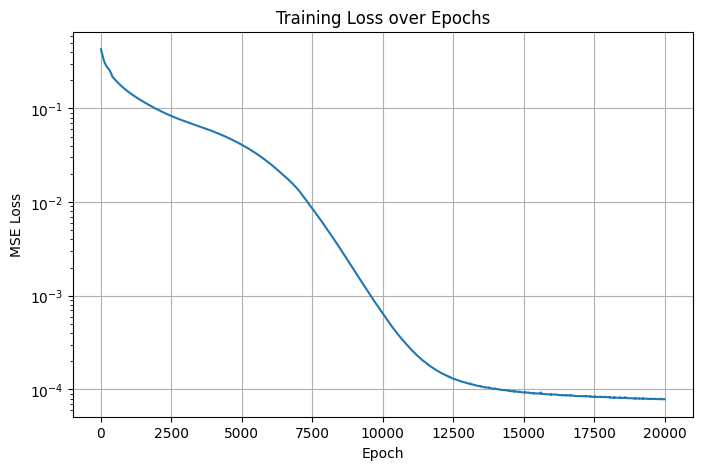

In [6]:
# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log') # Use log scale for better visibility if loss drops quickly
plt.grid(True)
plt.show()

### Evaluation and Visualization

Let's see how well our trained MLP approximates the sine curve. We'll generate predictions using the trained model and plot them against the true sine wave and the noisy training data.

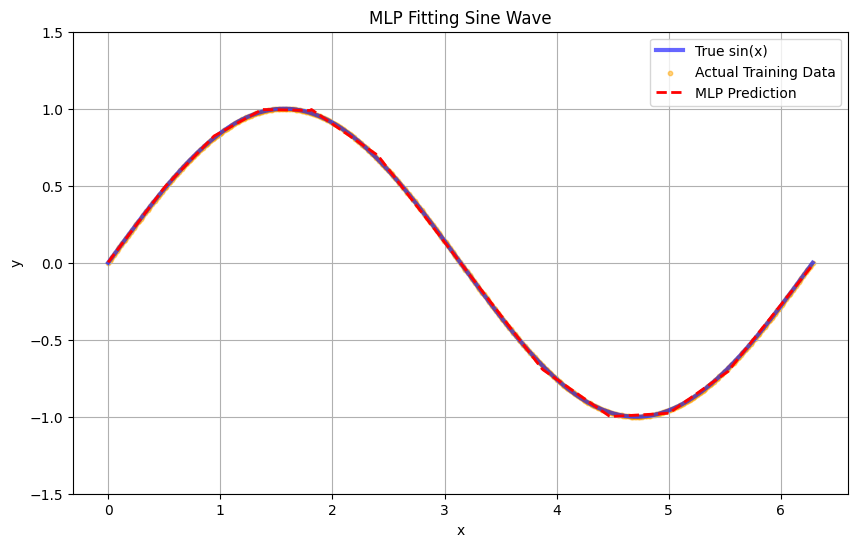

In [7]:
# Set model to evaluation mode (disables dropout, batch norm updates etc.)
model.eval()

# Generate predictions (no need for gradients during evaluation)
with torch.no_grad():
    y_pred = model(x_train) # Get predictions on the training x values

# Move predictions back to CPU for plotting with numpy/matplotlib
y_pred_cpu = y_pred.cpu().numpy()
x_cpu = x_train.cpu().numpy()
y_train_cpu = y_train.cpu().numpy()
y_true_cpu = y_true.numpy() # Original clean sine wave

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x_cpu, y_true_cpu, label='True sin(x)', linewidth=3, color='blue', alpha=0.6)
plt.scatter(x_cpu, y_train_cpu, label='Actual Training Data', s=10, alpha=0.5, color='orange')
plt.plot(x_cpu, y_pred_cpu, label='MLP Prediction', linewidth=2, color='red', linestyle='--')
plt.title("MLP Fitting Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.ylim(-1.5, 1.5) # Adjust y-axis limits if needed
plt.show()

# 4. Experiment Tracking Using Weights and Biases (WandB)

Now that we're familiar with the workflow that you'll adapt when approaching machine learning problems, let's integrate our experiment tracking using Weights and Biases (WandB) into the workflow. This is helpful for:

1.  **Track Experiments:** Log metrics (like loss) and hyperparameters for individual training runs.
2.  **Visualize Results:** Use the W&B dashboard to compare runs.
3.  **Perform Hyperparameter Sweeps:** Systematically explore the effect of different hyperparameters (network width and depth) on the model's ability to fit the sine wave using W&B Sweeps with a grid search strategy.

**Prerequisites:**
*   A Weights & Biases account (free at [https://wandb.ai/site](https://wandb.ai/site)).
*   The `wandb` library installed (`pip install wandb`).
*   You need to be logged into W&B in your environment. Run `wandb login` in your terminal and follow the prompts.

The main changes that we need to make are going to be to the training loop part of our code where we had evaluated the loss, backpropagated the error, and updated the weights. Remember that earlier we had manually tracked the loss progress. However, this may get tedious to track when we're working across multiple runs and we want to compare the results. 

In [8]:
import wandb
# let's say we want to use a different choice of hyperparameters to train
# in our case, we're going to track / change the hidden size, learning rate
config = {
    "input_size": 1,
    "hidden_size": 10,
    "output_size": 1,
    "learning_rate": 0.0001
}

model = MLP(config["input_size"], config["hidden_size"], config["output_size"]).to(device)
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])

# Initialize a new W&B run
run = wandb.init(config = config, project = "ai4science_tutorial")

num_epochs = 20000 # Increased epochs for better convergence
print_every = 1000 # Print loss every 1000 epochs

losses = [] # To store loss values for plotting

print("\nStarting Training...")
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()

    # Forward pass: Get predictions
    outputs = model(x_train)

    # Calculate loss
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    optimizer.zero_grad() # Clear previous gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update weights

    # Record loss
    losses.append(loss.item())

    # Print progress
    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.2e}')
        
        # Log loss to W&B (all you need to do):
        wandb.log({"loss": loss.item()})
        
# Close the W&B run
run.finish()
print("Training Finished!")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hyperion to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Starting Training...
Epoch [1000/20000], Loss: 3.56e-01
Epoch [2000/20000], Loss: 1.28e-01
Epoch [3000/20000], Loss: 6.45e-02
Epoch [4000/20000], Loss: 4.99e-02
Epoch [5000/20000], Loss: 4.47e-02
Epoch [6000/20000], Loss: 4.04e-02
Epoch [7000/20000], Loss: 3.68e-02
Epoch [8000/20000], Loss: 3.39e-02
Epoch [9000/20000], Loss: 3.15e-02
Epoch [10000/20000], Loss: 2.85e-02
Epoch [11000/20000], Loss: 2.42e-02
Epoch [12000/20000], Loss: 2.11e-02
Epoch [13000/20000], Loss: 1.80e-02
Epoch [14000/20000], Loss: 1.49e-02
Epoch [15000/20000], Loss: 1.17e-02
Epoch [16000/20000], Loss: 8.69e-03
Epoch [17000/20000], Loss: 6.09e-03
Epoch [18000/20000], Loss: 3.95e-03
Epoch [19000/20000], Loss: 2.42e-03


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch [20000/20000], Loss: 1.41e-03


loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
loss,0.00141


Training Finished!


Now all your hyperparameter tracking is done with W&B. You can also find the loss curves that your choice of hyperparameters yield. However, that's not everything that you can do with W&B. In fact, you can also leverage it to use hyperparameter search to find the best hyperparameters for your model. We can do this by performing a sweep over a bunch of hyperparameters and tracking the performance metric of the model.

In [9]:
# first we'll define a function which needs to be called everytime we set up a new run
def train_mlp():
    # Initialize a new W&B run
    # W&B agent will automatically populate wandb.config with hyperparameters
    run = wandb.init()
    config = wandb.config  # Get hyperparameters for this run

    model = MLP(input_size=1, hidden_size=config.hidden_dim, output_size=1)

    criterion = nn.MSELoss()
    # Use learning rate from config
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    start_time = time.time()
    epochs = config.epochs
    print_every = epochs // 10  # Print progress 10 times

    for epoch in range(epochs):
        model.train()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log metrics periodically to W&B
        if (epoch + 1) % print_every == 0 or epoch == 0:
            wandb.log({"epoch": epoch + 1, "loss": loss.item()})

    training_time = time.time() - start_time
    print(
        f"Run {run.name} finished training in {training_time:.2f}s. Final Loss: {loss.item():.6f}"
    )

    model.eval()
    with torch.no_grad():
        y_pred = model(x_train)
        final_mse = criterion(y_pred, y_true)

    wandb.log({"final_mse": final_mse.item(), "training_time": training_time})

    plt.figure(figsize=(8, 5))
    plt.plot(
        x_train.cpu().numpy(), y_true.cpu().numpy(), label="True sin(x)", linewidth=2
    )
    plt.plot(
        x_train.cpu().numpy(),
        y_pred.cpu().numpy(),
        label=f"MLP Prediction (Run {run.name})",
        linestyle="--",
        color="red",
    )
    plt.title(f"Final Fit (MSE: {final_mse.item():.4f})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    wandb.log({"final_fit_plot": wandb.Image(plt)})
    plt.close()

    run.finish()

In [10]:
sweep_config = {
    "method": "grid",  # Strategy: grid search
    "metric": {
        "name": "final_mse",  # Metric to optimize
        "goal": "minimize",  # We want to minimize the Mean Squared Error
    },
    "parameters": {
        "hidden_dim": {"values": [16, 32, 64]},  # Test these widths
        "learning_rate": {"values": [0.01, 0.005, 0.001]},  # Test these learning rates
        "epochs": {"values": [20000]}
    },
}

In [11]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project = "ai4science_tutorial")

# Start the sweep
wandb.agent(sweep_id, function=train_mlp)

Create sweep with ID: doitr9gh
Sweep URL: https://wandb.ai/hyperion/ai4science_tutorial/sweeps/doitr9gh


wandb: Agent Starting Run: rny5msur with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 16
wandb: 	learning_rate: 0.01


Run good-sweep-1 finished training in 8.26s. Final Loss: 0.000040


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,2e-05
loss,4e-05
training_time,8.26109


wandb: Agent Starting Run: fhjy4dzj with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 16
wandb: 	learning_rate: 0.005


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run frosty-sweep-2 finished training in 8.26s. Final Loss: 0.000035


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,4e-05
loss,4e-05
training_time,8.26423


wandb: Agent Starting Run: 9vyry8jr with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 16
wandb: 	learning_rate: 0.001


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run rich-sweep-3 finished training in 8.73s. Final Loss: 0.000128


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,0.00013
loss,0.00013
training_time,8.7294


wandb: Agent Starting Run: 61xtvi70 with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.01


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run serene-sweep-4 finished training in 9.07s. Final Loss: 0.000019


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,3e-05
loss,2e-05
training_time,9.07082


wandb: Agent Starting Run: anl0dobd with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.005


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run electric-sweep-5 finished training in 9.05s. Final Loss: 0.000043


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,5e-05
loss,4e-05
training_time,9.04837


wandb: Agent Starting Run: rrd8hvf9 with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.001


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run vivid-sweep-6 finished training in 9.16s. Final Loss: 0.000015


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,2e-05
loss,2e-05
training_time,9.16016


wandb: Agent Starting Run: a6x4l7xv with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.01


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run spring-sweep-7 finished training in 11.15s. Final Loss: 0.000013


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,1e-05
loss,1e-05
training_time,11.15192


wandb: Agent Starting Run: gaok9m4l with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.005


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run wobbly-sweep-8 finished training in 12.12s. Final Loss: 0.000003


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,0.0
loss,0.0
training_time,12.11926


wandb: Agent Starting Run: gnugcpu8 with config:
wandb: 	epochs: 20000
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.001


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Run devoted-sweep-9 finished training in 11.45s. Final Loss: 0.000098


epoch,▁▂▂▃▄▄▅▆▇▇█
final_mse,▁
loss,█▁▁▁▁▁▁▁▁▁▁
training_time,▁
epoch,20000
final_mse,8e-05
loss,0.0001
training_time,11.4495


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


After the agent finishes running all the combinations:

1.  **Go to the W&B Project Page:** Navigate to the project link printed above (or find it in your W&B dashboard).
2.  **Select Sweeps:** Click on the "Sweeps" tab in the left sidebar.
3.  **Explore:** You will find your sweep listed. Click on it to see:
    *   **Parameter Importance Plot:** Shows which hyperparameters had the most impact on the `final_mse`.
    *   **Parallel Coordinates Plot:** Visualizes the relationship between hyperparameter choices and the resulting metric across all runs.
    *   **Runs Table:** A detailed table listing all runs, their hyperparameters, and logged metrics. You can sort and filter this table.

This allows you to easily identify the best performing hyperparameter combinations for your specific problem and gain insights into how width and learning rate affect the MLP's ability to fit the sine wave.

## 5. Conclusions and Things To Try

We successfully built and trained a simple MLP using PyTorch to approximate the sine function. Additionally, we used Weights & Biases (WandB) to track and visualize the training process and sweep through different choices of hyperparameters.

**Key Takeaways:**
*   MLPs are structured layers of neurons with weights, biases, and activation functions.
*   Non-linear activation functions (like ReLU) are crucial for learning complex patterns.
*   Training involves a cycle of forward pass, loss calculation, backpropagation, and optimization.
*   PyTorch provides convenient modules (`nn.Module`, `nn.Linear`, `nn.ReLU`, `nn.MSELoss`) and optimizers (`optim.Adam`) to build and train neural networks.

**Further Exploration:**
*   Try different activation functions (e.g., `nn.Tanh`). Tanh might be better suited for sine as its output is bounded between -1 and 1.
*   Experiment with the number of hidden layers and neurons per layer.
*   Adjust the learning rate and number of epochs.
*   Try fitting other mathematical functions.
*   Explore other optimizers or loss functions.